<a href="https://colab.research.google.com/github/WuodOdhis/AIRbnbsila/blob/main/Bird_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#checking the internet connection for the python script.
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
#Installation of the necessary libraries.
!pip install fastcore==<0.1.34>
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install fastcore==<0.1.34>'


In [ ]:
!pip install duckduckgo_search
!pip install fastbook


In [6]:
import fastbook
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [7]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'http://2.bp.blogspot.com/-TA1D79yxcnM/Tyy6ng42rbI/AAAAAAAAAnc/-4s-bZaYc_U/s1600/colorfull+bird+HD+wallpaper.jpg'

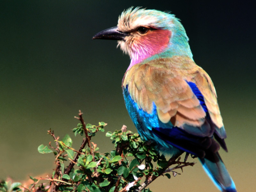

In [8]:
#Download images of birds and non-birds
from fastdownload import download_url
dest = 'birds.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


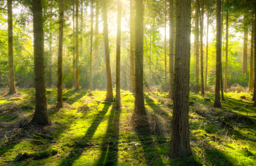

In [9]:
#downloading some forest photos.
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [10]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


In [11]:
#removing photos that were not downloaded correctly.
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

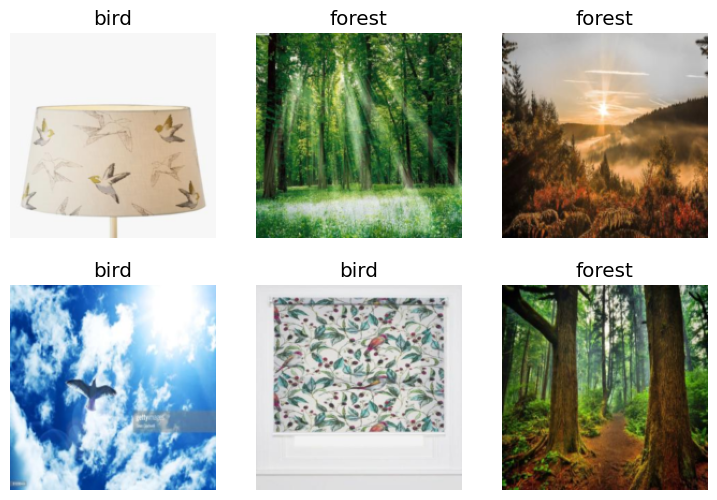

In [12]:
#Training of the models using datablocks.
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.009535,0.109650,0.031250,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.245122,0.013503,0.000000,00:30
1,0.168240,0.006132,0.000000,00:30
2,0.121012,0.009440,0.000000,00:30


In [14]:
#Identification of bird earlier.
is_bird,_,probs = learn.predict(PILImage.create('birds.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
